## Готово
###                               <center>результаты на лидерборде<center>
  
  Модели              | open_cv_HOG    |   hand_HOG
  ------------------  | -------------- | -------------
  полносвязная сеть   |  0.98342       |     0.97657
  log_reg             |  0.98628       |     0.98042
  RFC                 |  0.97114       |     0.95128
  KNN                 |  0.97985       |     0.97342
  GBBust              |  0.97485       |     0.96228

#### Как показали эксперименты лучшее значение показал логистическая регрессия.
#### Ручной HOG показал себя несколько хуже чем из коробки, так как не реализует 
#### различные обработчики изображения.

In [3]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
train = np.loadtxt('digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('digit/test.csv', delimiter=',', skiprows=1)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

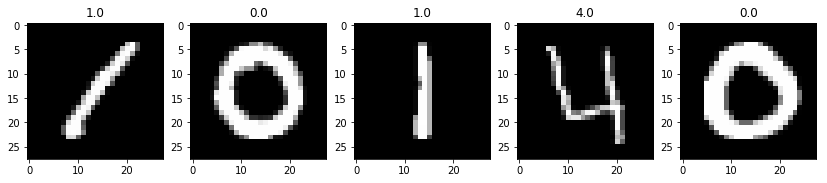

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


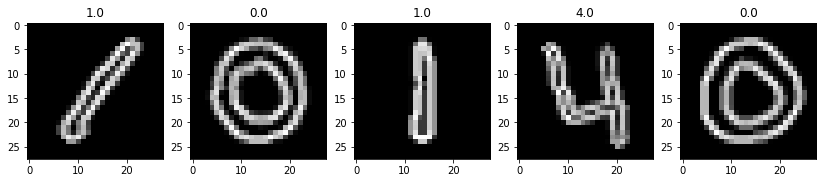

In [14]:
# визуализируем даннве после свертки
fig = plt.figure(figsize=(20, 10))
kernel = np.array([[1,0,-1]])
kernel2 = np.array([[1],[0],[-1]])

for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    dx = cv2.filter2D(img,-1,kernel)
    dy = cv2.filter2D(img,-1,kernel2)
    g = np.sqrt(dx*dx + dy*dy)
    tetta = np.arctan(dy/dx)
    #print(dst)
    plt.imshow(g, cmap='gray');
    #plt.imshow(tetta, cmap='gray')
    subplot.set_title('%s' % train_label[i - 1]);



## Использование алгоритма HOG из состава OpenCV

In [4]:

winSize = (28,28)
blockSize = (8,8)
blockStride = (4,4)
cellSize = (4,4)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradient = True
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)

train_hist = []
test_hist = []


for i in range(len(train_img)):
    train_img_p = train_img[i].astype(np.uint8)
    train_hist.append(hog.compute(train_img_p).reshape(-1))

for i in range(len(test_img)):
    test_img_p = test_img[i].astype(np.uint8)
    test_hist.append(hog.compute(test_img_p).reshape(-1))


train_hist = np.array(train_hist)
test_hist = np.array(test_hist) 

print(train_hist.shape)    
    
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(train_label, train_hist, test_size=0.2, random_state=42)    

(42000, 1296)


# HOG сделанный в ручную

### В соответствии со статьей https://www.learnopencv.com/histogram-of-oriented-gradients/
 
 1. разобъем картинки на части 
 + посчитаем для этих частей диаграммы градиентов
 + соберем эти части в группы 
 + проведем для полученных групп нормализацию
 + полученные группы переведем в вектора и сложим в единый большой вектор
 + для получившихся данных проведем классификацию


In [15]:

def get_grad_and_tetta(data_img, kernel_x,kernel_y):
    grad_x = np.zeros_like(data_img)
    grad_y = np.zeros_like(data_img)
    for i in range(len(data_img)):
        grad_x[i] = cv2.filter2D(data_img[i],-1,kernel_x)
        grad_y[i] = cv2.filter2D(data_img[i],-1,kernel_y)
    grad = np.sqrt(grad_x*grad_x+grad_y*grad_y)
    tetta = np.arctan(grad_y/grad_x)*180/np.pi+90    
    tetta = np.nan_to_num(tetta)   
    return (grad, tetta) 


def get_HOG(grad,tetta, d_hog=4, bins=9 ):
    size_x = grad[0].shape[0]//d_hog
    size_y = grad[0].shape[1]//d_hog
    result_hist = np.zeros([len(grad), size_x, size_y, bins], dtype=float)
    delta = 180 / bins
    for n in range(len(grad)):
        if n%5000 == 0:
            print(n)
        for i in range(size_x):
            for j in range(size_y):
                part_g = grad[n][i*d_hog:(i+1)*d_hog, j*d_hog:(j+1)*d_hog]
                part_t = tetta[n][i*d_hog:(i+1)*d_hog, j*d_hog:(j+1)*d_hog]
                #res_part = [0.0]*bins
                res_part = np.zeros(bins, dtype=float)
                for k in range(part_g.shape[0]):
                    for m in range(part_g.shape[1]):
                        p, t = int(part_t[k][m]//delta), part_t[k][m]%delta/delta
                        g_1 = part_g[k][m] * t
                        res_part[p%bins]+= g_1
                        res_part[(p+1)%bins] += part_g[k][m] - g_1
                result_hist[n][i][j] = res_part
    result_hist1 = np.concatenate([result_hist[:,:,:-1,:],result_hist[:,:,1:,:]],axis=3)
    result_hist11 = np.concatenate([result_hist1[:,:-1,:,:],result_hist1[:,1:,:,:]],axis=3)
    norm_vect = np.sqrt(np.sum(result_hist11*result_hist11, axis=3))
    result_hist3 = np.nan_to_num(result_hist11/norm_vect[:,:,:, np.newaxis])
    sh = np.array(result_hist3.shape)
    result_hist4 = result_hist3[:,:].reshape(sh[0],np.prod(sh[1:]))
    return result_hist4
    


### Применяем ручной HOG 

In [5]:

kernel = np.array([[-1,0,1]])
kernel2 = np.array([[-1],[0],[1]])

train_grad2, train_tetta2 = get_grad_and_tetta(train_img, kernel, kernel2)
test_grad2, test_tetta2 = get_grad_and_tetta(test_img, kernel, kernel2)

train_hist2 = get_HOG(train_grad2, train_tetta2)
test_hist2 = get_HOG(test_grad2, test_tetta2)



from sklearn.model_selection import train_test_split
y_train2, y_val2, x_train2, x_val2 = train_test_split(
    train_label, train_hist2, test_size=0.2, random_state=42)



/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


0
5000
10000
15000
20000
25000
30000
35000
40000


/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


0
5000
10000
15000
20000
25000


## Используем нейронную модель
### Собираем полносвязную сеть для обучения

In [35]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(32,
                             input_dim=x_train2.shape[1],
                             activation='relu'))

model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Выводим информацию о модели

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                41504     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 41,834
Trainable params: 41,834
Non-trainable params: 0
_________________________________________________________________


### One hot encoding разметки

In [16]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

In [6]:
from keras.utils import np_utils
y_train_labels2 = np_utils.to_categorical(y_train2)

### Запускаем обучение

In [38]:
model.fit(x_train2, y_train_labels2, 
          batch_size=32, validation_split=0.2,
          epochs=10)

Train on 26880 samples, validate on 6720 samples
Epoch 1/10
26880/26880 [==============================] - 4s 131us/step - loss: 0.2580 - acc: 0.9394 - val_loss: 0.1059 - val_acc: 0.9705
Epoch 2/10
26880/26880 [==============================] - 2s 86us/step - loss: 0.0842 - acc: 0.9748 - val_loss: 0.0859 - val_acc: 0.9749
Epoch 3/10
26880/26880 [==============================] - 2s 86us/step - loss: 0.0653 - acc: 0.9799 - val_loss: 0.0813 - val_acc: 0.9750
Epoch 4/10
26880/26880 [==============================] - 2s 86us/step - loss: 0.0532 - acc: 0.9836 - val_loss: 0.0791 - val_acc: 0.9759
Epoch 5/10
26880/26880 [==============================] - 2s 89us/step - loss: 0.0454 - acc: 0.9861 - val_loss: 0.0842 - val_acc: 0.9756
Epoch 6/10
26880/26880 [==============================] - 2s 88us/step - loss: 0.0401 - acc: 0.9867 - val_loss: 0.0795 - val_acc: 0.9759
Epoch 7/10
26880/26880 [==============================] - 2s 89us/step - loss: 0.0336 - acc: 0.9895 - val_loss: 0.0813 - val_acc

In [63]:
y_train_labels.shape

(33600, 10)

In [64]:
x_train.shape

(33600, 1296, 1)

### Предсказываем класс объекта

In [39]:
pred_val = model.predict_classes(x_val2)

In [40]:
pred_proba = model.predict_proba(x_val2)

### Оцениваем качество решение на валидационной выборке

In [43]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val2, pred_val))

Accuracy: 0.9771428571428571


In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       816
         1.0       0.98      0.99      0.99       909
         2.0       0.97      0.97      0.97       846
         3.0       0.98      0.97      0.98       937
         4.0       0.98      0.97      0.98       839
         5.0       0.97      0.99      0.98       702
         6.0       0.99      0.98      0.98       785
         7.0       0.98      0.98      0.98       893
         8.0       0.96      0.96      0.96       835
         9.0       0.96      0.98      0.97       838

   micro avg       0.98      0.98      0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



In [45]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[808   1   1   0   0   0   3   0   0   3]
 [  0 900   0   3   2   1   0   1   2   0]
 [  3   4 823   5   3   0   0   2   4   2]
 [  0   0   5 907   0   7   0   3  13   2]
 [  1   3   2   0 816   1   4   4   1   7]
 [  1   0   0   2   1 692   1   0   3   2]
 [  4   3   0   0   2   4 768   0   4   0]
 [  0   1   6   1   1   1   0 872   1  10]
 [  3   2   5   3   2   5   1   4 803   7]
 [  0   0   3   0   2   2   0   6   6 819]]


### Предсказания на тестовыйх данных

In [48]:
pred_test = model.predict_classes(test_hist2)

### Визуализируем предсказания

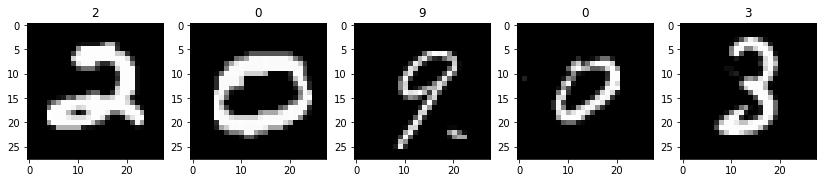

In [49]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

### Готовим файл для отправки

In [50]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

## Используем другие ML-модели

In [7]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


### Логистическая регрессия

In [8]:
cls = LogisticRegression()
cls.fit(x_train2, y_train2)
x_pred2 = cls.predict(x_val2)
print('Accuracy: %s' % accuracy_score(y_val2, x_pred2))
pred_test = cls.predict(test_hist2)
with open('submit_lr_h.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

/home/user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.9782142857142857


### Градиентный бустинг

In [12]:
cls = GradientBoostingClassifier()
cls.fit(x_train2, y_train2)
x_pred2 = cls.predict(x_val2)
print('Accuracy: %s' % accuracy_score(y_val2, x_pred2))
pred_test = cls.predict(test_hist2)
with open('submit_GBC_h.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

Accuracy: 0.9620238095238095


### Случайный лес

In [9]:
cls = RandomForestClassifier(n_jobs=-1)
cls.fit(x_train2, y_train2)
x_pred2 = cls.predict(x_val2)
print('Accuracy: %s' % accuracy_score(y_val2, x_pred2))
pred_test = cls.predict(test_hist2)
with open('submit_RFC_h.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

/home/user/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9554761904761905


### K-ближайших

In [13]:
cls = KNeighborsClassifier(n_jobs=-1)
cls.fit(x_train2, y_train2)
x_pred2 = cls.predict(x_val2)
print('Accuracy: %s' % accuracy_score(y_val2, x_pred2))
pred_test = cls.predict(test_hist2)
with open('submit_KNC_h.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

Accuracy: 0.9767857142857143


## Попробуем использовать стекинг моделей

In [1]:
import pandas as pd

In [9]:
model1 = pd.read_csv('submit.txt')
model2 = pd.read_csv('submit_lr.txt')
model3 = pd.read_csv('submit_GBC.txt')
model4 = pd.read_csv('submit_RFC.txt')
model5 = pd.read_csv('submit_KNC.txt')
model6 = pd.read_csv('submit_h.txt')
model7 = pd.read_csv('submit_lr_h.txt')
model8 = pd.read_csv('submit_GBC_h.txt')
model9 = pd.read_csv('submit_RFC_h.txt')
model10 = pd.read_csv('submit_KNC_h.txt')


In [10]:
x_pred_df = pd.DataFrame()
x_pred_df['model1'] = model1['Label']
x_pred_df['model2'] = model2['Label']
x_pred_df['model3'] = model3['Label']
x_pred_df['model4'] = model4['Label']
x_pred_df['model5'] = model5['Label']
x_pred_df['model6'] = model6['Label']
x_pred_df['model7'] = model7['Label']
x_pred_df['model8'] = model8['Label']
x_pred_df['model9'] = model9['Label']
x_pred_df['model10'] = model10['Label']



x_pred_df.head()

,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10
0,2,2,2,2,2,2,2,2,2,2
1,0,0,0,0,0,0,0,0,0,0
2,9,9,9,9,9,9,9,9,9,9
3,0,0,9,0,0,0,0,0,0,0
4,3,3,3,8,3,3,3,3,3,3


In [31]:
def get_res(s):
    x = s.value_counts()
    return list(x.keys())[0]

In [32]:
x_pred_df['res']= x_pred_df.apply(get_res, axis=1)

In [33]:
x_pred_df.head()

,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,res
0,2,2,2,2,2,2,2,2,2,2,2
1,0,0,0,0,0,0,0,0,0,0,0
2,9,9,9,9,9,9,9,9,9,9,9
3,0,0,9,0,0,0,0,0,0,0,0
4,3,3,3,8,3,3,3,3,3,3,3


In [34]:
with open('submit_stek.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in x_pred_df.iterrows():
        dst.write('%s,%s\n' % (i, int(p['res'])))

## Результаты

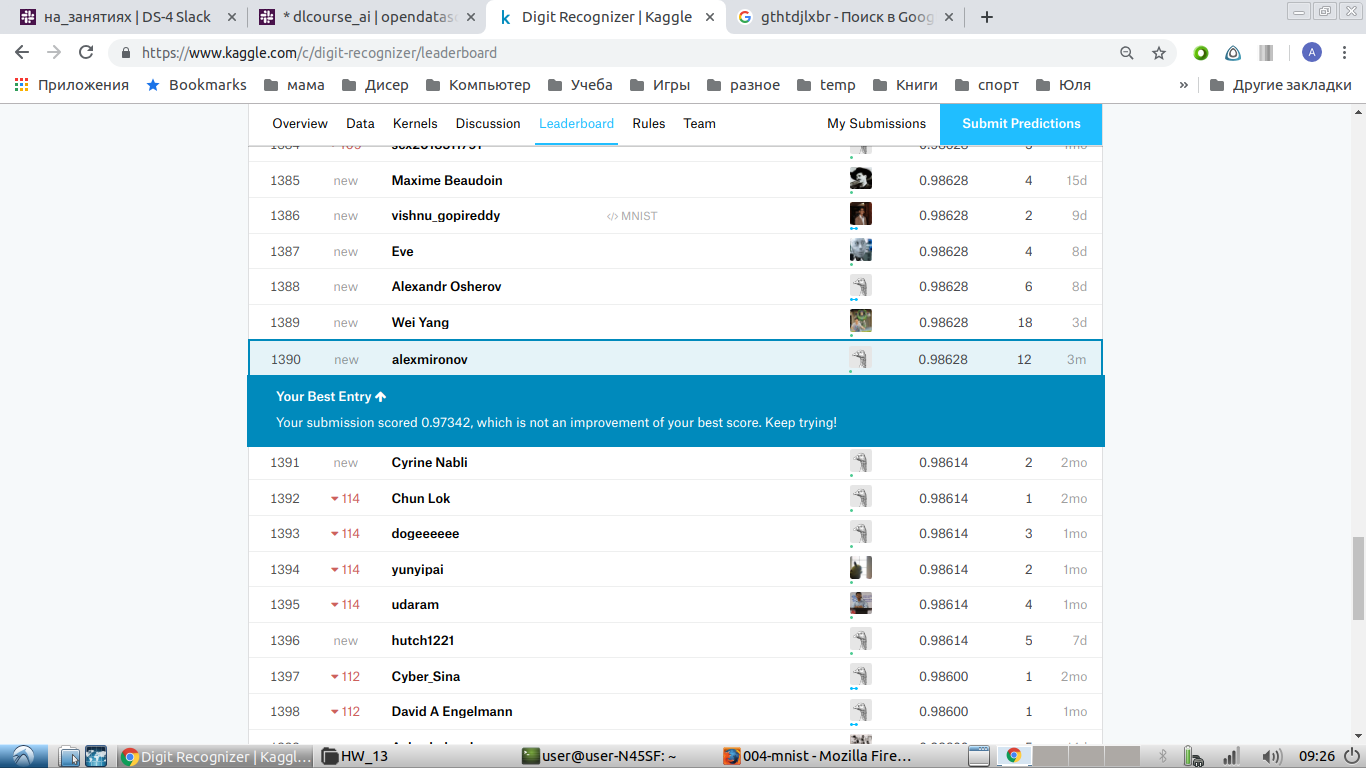

In [3]:
from IPython.display import Image
Image("commit.png")

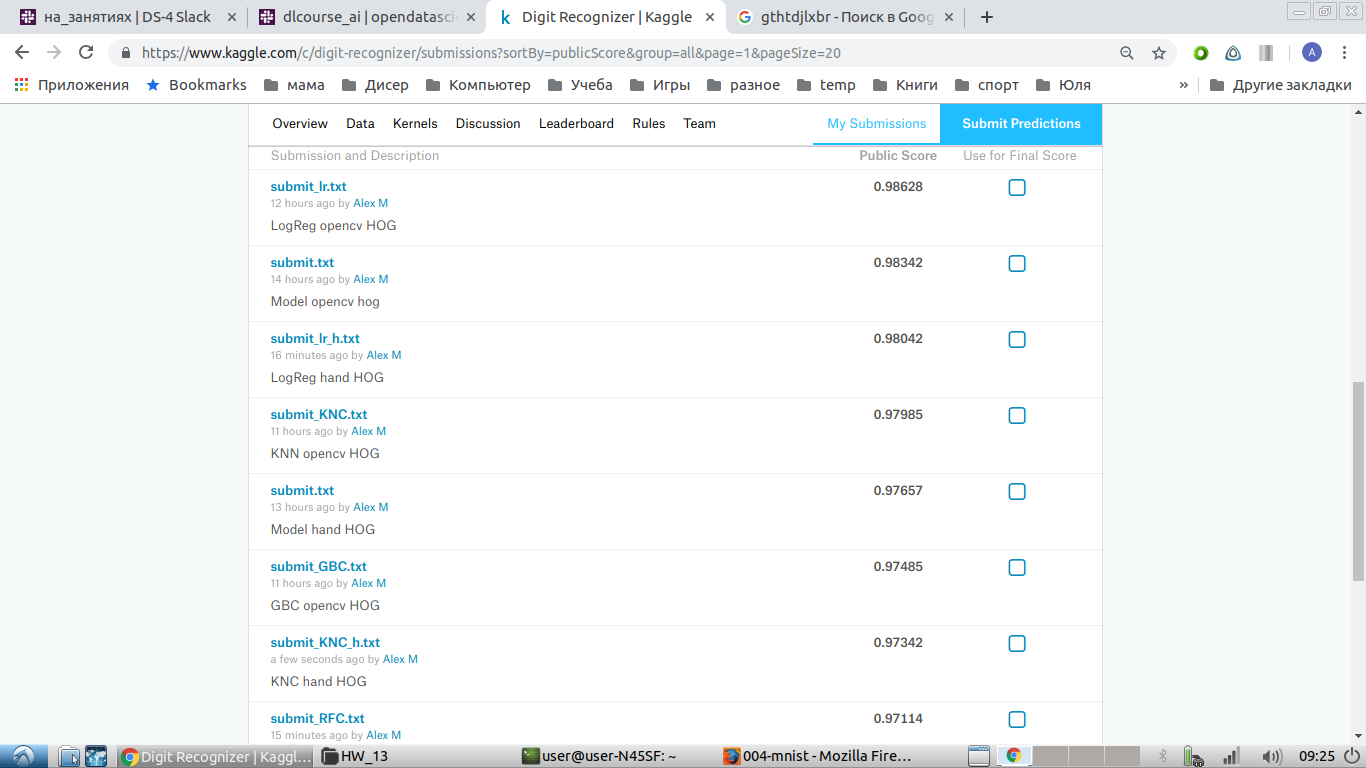

In [4]:
from IPython.display import Image
Image("all_commit.png")